### Machine Learning: Assignment 4

### Topics:
- Ensemble methods
- AdaBoost
- PCA
- LDA
- K means clustering

By: Dema Omar , Aya Fodi

## Part 1 - Bagging
In HW3, we helped Charles Darvin with regression of abalone problem and now, we will try combining multiple regression models instead of just one, hopefully for a better result.

In [ ]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

In [ ]:
# load the data, transform it

df = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv', header=None)
data = df.to_numpy()

train, test = train_test_split(data, test_size=0.2, random_state=21)

X_train, y_train = train[:,:-1], train[:, -1]
X_test, y_test = test[:,:-1], test[:, -1]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Our task is to complete the following bagging model. Specifically:
- fit(self, data, targets) - train n_estimators regressors, each with data in size n=len(data) that is drawn from the original data, with repititions.
- predict(self, test) - predict the result for all the regressors as learned.



In [ ]:
from sklearn.linear_model import LinearRegression

class LinRegCombiner():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators

    def fit(self, data, targets):
        self.regressors = []
        n = len(data)

        for _ in range(self.n_estimators):
            # Implement here
            indices = np.random.choice(n, n, replace=True)
            X_train = data[indices]
            y_train = targets[indices]

            reg = LinearRegression()
            reg.fit(X_train, y_train)

            self.regressors.append(reg)


    def predict(self, test):
        preds = []
        # Implement here
        for reg in self.regressors:
            preds.append(reg.predict(test))
        return np.mean(preds, axis=0)

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)

In [ ]:
# Run for 100 estimators

obj = LinRegCombiner(n_estimators=100)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.806079896670367
MSE test = 5.383882146680212


Now, implement the same but using ridge regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin

class RidgeLinRegCombiner(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators, alpha=1.0):
        self.n_estimators = n_estimators
        self.alpha = alpha

    def fit(self, data, targets):
        self.regressors = []
        n=len(data)
        for _ in range(self.n_estimators):
            # Implement here
            indices = np.random.choice(n, n, replace=True)
            X_train = data[indices]
            y_train = targets[indices]

            reg = Ridge(alpha=self.alpha)
            reg.fit(X_train, y_train)

            self.regressors.append(reg)


    def predict(self, test):
        preds = []
        # Implement here
        for reg in self.regressors:
            preds.append(reg.predict(test))
        return np.mean(preds, axis=0)

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)

Tune the hyperparameters for RidgeLinRegCombiner.

In [ ]:
# Implement here
from sklearn.model_selection import cross_val_score

n_estimators_range = [10, 50, 100, 150, 200, 250, 300]
alphas =  [0.01, 0.1, 1.0, 0.001]

best_n_estimators = None
best_alpha = None
best_mse = float('inf')

for n in n_estimators_range:
  for alpha in alphas:
    reg = RidgeLinRegCombiner(n_estimators=n, alpha=alpha)
    reg.fit(X_train, y_train)
    mse = reg.score(X_test, y_test)

    if mse < best_mse:
      best_mse = mse
      best_n_estimators = n
      best_alpha = alpha

print(f'Best n_estimators: {best_n_estimators}')
print(f'Best alpha: {best_alpha}')
print(f'Best MSE: {best_mse}')




Best n_estimators: 10
Best alpha: 0.01
Best MSE: 5.366475133116598


We got MSE train = 4.8051 and MSE test = 5.3809 in the Ridge Regression model, and we got MSE train = 4.8060 and MSE test = 5.3839 in the Linear Regression model. The MSE values for the training data are nearly identical, indicating that both models fit the training set similarly. However, the Ridge Regression model has a slightly lower MSE on the test set compared to the Linear Regression model. This suggests that the Ridge Regression model performs marginally better in terms of generalization, as it has a lower error on unseen data. Therefore, the Ridge Regression model is preferred for this particular problem, as it is more likely to make accurate predictions on new data.</font>

In [ ]:
# Run for n estimators and alpha you found

obj = RidgeLinRegCombiner(n_estimators=best_n_estimators, alpha=best_alpha)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.805144579390529
MSE test = 5.380895175223886


## Part 2 - Clustering

In this question we will implement : partitional clustering and specifically – k means algorithm , and see some nice applications.

import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Complete the missing implementation of Kmeans. Since there are k clusters, we will label each point with {0,..,k-1}.

In [ ]:
class Kmeans:

	def __init__(self, n_clusters, max_iter=100, random_state=123):
		self.n_clusters = n_clusters
		self.max_iter = max_iter
		self.random_state = random_state

	def initialize_centroids(self, X):
		np.random.RandomState(self.random_state)
		random_idx = np.random.permutation(X.shape[0])
		centroids = X[random_idx[:self.n_clusters]]
		return centroids

	def reassign_centroids(self, X, labels):
		centroids = np.zeros((self.n_clusters, X.shape[1]))
		# Implement here
		for k in range(0, self.n_clusters):
			centroids[k] = np.mean(X[labels == k], axis=0)
		return centroids

	def compute_distance(self, X, centroids):
		distance = np.zeros((X.shape[0], self.n_clusters))
		for k in range(self.n_clusters):
			row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
			distance[:, k] = np.square(row_norm)
		return distance

	def find_closest_cluster(self, distance):
		return np.argmin(distance, axis=1)

	def compute_sse(self, X, labels, centroids):
		distance = np.zeros(X.shape[0])
		for k in range(self.n_clusters):
			distance[labels == k] = np.linalg.norm(X[labels == k] - centroids[k], axis=1)
		return np.sum(np.square(distance))

	def fit(self, X):
		self.centroids = self.initialize_centroids(X)
		for i in range(self.max_iter):
			old_centroids = self.centroids
			# For each point, calculate distance to all k clustes.
			self.labels = self.find_closest_cluster( self.compute_distance( X, self.centroids)) 	# Assign the labels with closest distance' cluster.
			self.centroids = self.reassign_centroids( X, self.labels) # Update the centroids
			if np.all(old_centroids == self.centroids):
				break
		self.error = self.compute_sse(X, self.labels, self.centroids)

	def predict(self, X):
		distance = self.compute_distance(X, self.centroids)
		return self.find_closest_cluster(distance)

Load exams data, convert to numpy and plot it

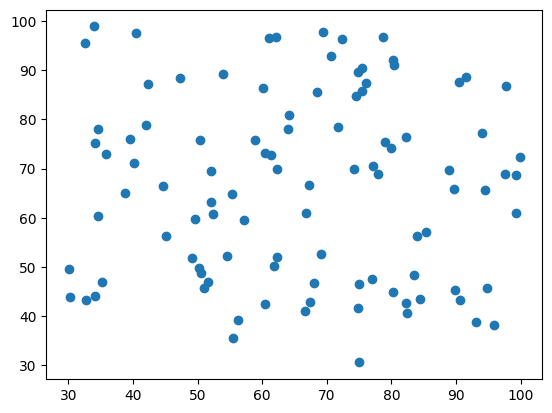

In [ ]:
db = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw4/exams.csv', header=None).to_numpy()
data, labels = db[:,:-1], db[:,-1]

plt.scatter(data[:, 0], data[:, 1])
plt.show()

We are going to divide the data into 2 clusters. <br/>
Define Kmeans object and fit the data.

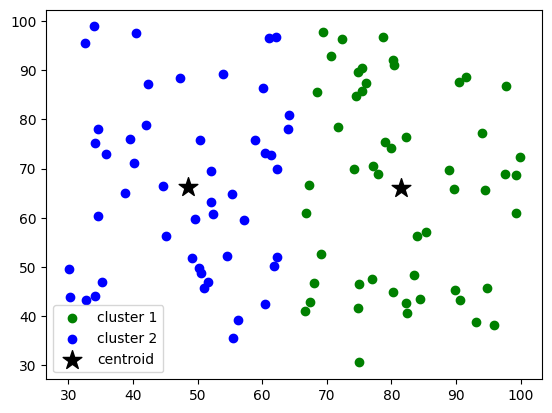

In [ ]:
clust = Kmeans(n_clusters=2)
clust.fit(data)

# This code plots the clustered data with centroids
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]

plt.scatter(c0[:,0], c0[:,1], c='green', label='cluster 1')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()

plt.show()

I choose k=6 because, as observed in the graph, there is an abrupt change  from k=1 to k=6. After k=6, the change becomes more gradual, indicating that the optimal number of clusters is likely 6. </font>

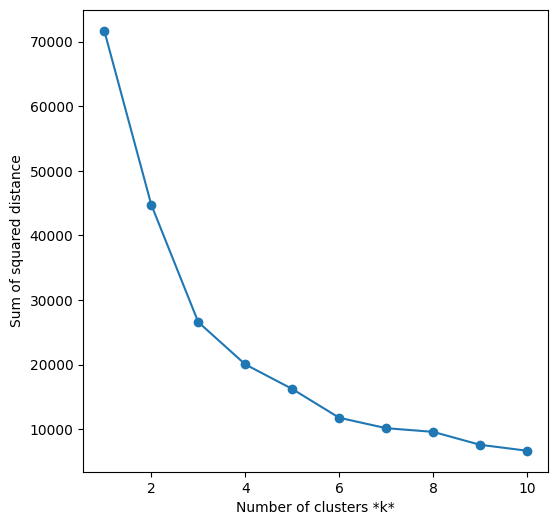

In [ ]:
sse = []
list_k = list(range(1, 11))

for k in list_k:
  clust = Kmeans(n_clusters=k)
  clust.fit(data)
  error_of_current_clustering = clust.compute_sse(data, clust.labels, clust.centroids)
  sse.append(error_of_current_clustering)

'''Plot sse against k'''
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

Apply clustering with the selected k

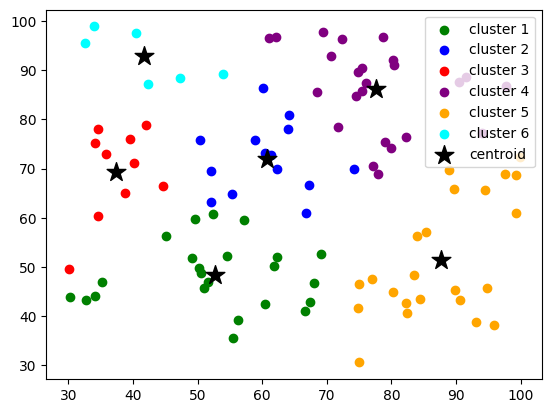

In [ ]:
# Implement here
clust = Kmeans(n_clusters=6)
clust.fit(data)

# This code plots the clustered data with centroids
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]
c2 = data[labels == 2]
c3 = data[labels == 3]
c4 = data[labels == 4]
c5 = data[labels == 5]

plt.scatter(c0[:,0], c0[:,1], c='green', label='cluster 1')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='cluster 2')
plt.scatter(c2[:,0], c2[:,1], c='red', label='cluster 3')
plt.scatter(c3[:,0], c3[:,1], c='purple', label='cluster 4')
plt.scatter(c4[:,0], c4[:,1], c='orange', label='cluster 5')
plt.scatter(c5[:,0], c5[:,1], c='cyan', label='cluster 6')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()

plt.show()


Now, we will compress some image using k-means. <br/>
Here, we are given image from size 400x600x3. The last parameter is the number of channels. 3 channels means that the image is colored (unlike 1 in, which is grayscale). <br/>
Our goal is to reduce the number of colors to 20 and represent (compress) the photo using those 20 colors only. <br/>

Motivation: the original image requires 400x600x3x8 bits, while the new image will require only 400x600x5 + 20x24 bits, almost 5 times smaller!<br/>
To really do this, we will take the image and treat every pixel as a data point, where each data point is in 3d space (r,g,b). Then, we cluster into 20 centroids, and we assign each pixel to a centroid. This will allow us to represent the image using only 20 colors.


In [ ]:
#@title helper function

import urllib.request

def read_image(url):
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    return cv2.imdecode(arr, -1)

In [ ]:
from sklearn.cluster import KMeans
import cv2

img = read_image('https://sharon.srworkspace.com/ml/datasets/hw4/image.jpg')
img_size = img.shape

# Reshape it to be 2-dimension
X = img.reshape(img_size[0] * img_size[1], img_size[2])		# Turn hxwx3 into (h*w)x3

# Run the Kmeans algorithm
km = KMeans(n_clusters=20)
km.fit(X)

'''
The km has the following properties:
(*) km.labels_ is an array size (pixels, 20), will give each pixel its class from 20 classes (values are between 0-19)
(*) km.cluster_centers_ is an array size 20x3, where the ith row represents the color value for the ith label.
	For example, cluster_centers_[0] = [r,g,b], the first center.
'''

# Use the centroids to compress the image
img_compressed = km.cluster_centers_[km.labels_] # Use cluster_centers_ and labels_
img_compressed = np.clip(img_compressed.astype('uint8'), 0, 255)

# Reshape X_recovered to have the same dimension as the original image 128 * 128 * 3'''
img_compressed = img_compressed.reshape(img_size[0], img_size[1], img_size[2])

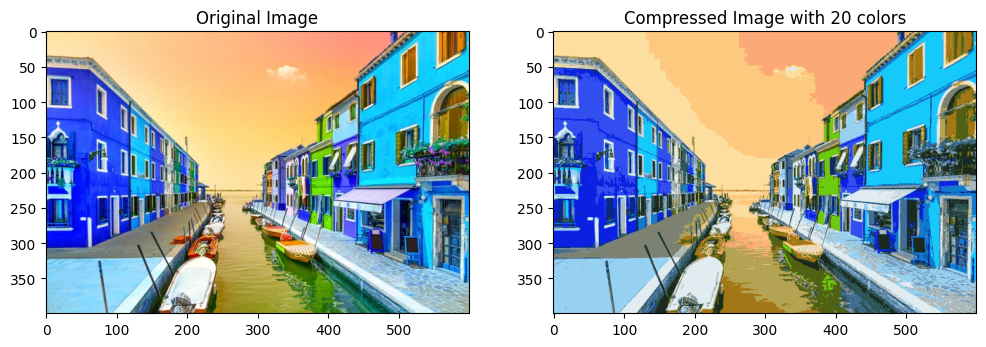

In [ ]:

# Plot the original and the compressed image next to each other'''
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_compressed)
plt.title(f'Compressed Image with {km.n_clusters} colors')

plt.show()

## load smiling dataset

In the third question, we will deal with the Smiling-face dataset, which determines if a person is smiling or not. You will try several models and hope to get good results<br/>
For now our task is: run the following section and make sure your understand what's going on.

Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will give you the json file, which you will upload here.

In [ ]:
# The script expects you to upload JSON file to it!

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download chazzer/smiling-or-not-face-data
! unzip -q smiling-or-not-face-data.zip -d data

Saving kaggle.json to kaggle.json
ref                                                        title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                📚 Students Performance Dataset 📚                  66KB  2024-06-12 23:09:20          23797        498  1.0              
waqi786/cars-dataset-2010-2020                             Cars Dataset (2010-2020)                          96KB  2024-07-23 05:49:46           1132         27  1.0              
waqi786/e-commerce-clickstream-and-transaction-dataset     E-commerce Clickstream and Transaction Dataset     1MB  2024-07-24 10:17:49            849         28  1.0              
anishvijay/global-renewable-energy-and-indicators-dataset  Global 

import libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

process the images

In [ ]:
def proccess_data(folder):
	image_arrays = []
	for filename in os.listdir(folder):
		file_path = os.path.join(folder, filename)
		image = cv2.imread(file_path)
		gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image_arrays.append(gray_image)
	return np.array(image_arrays)

smile = proccess_data('./data/smile')
non_smile = proccess_data('./data/non_smile')

dataset = np.vstack((smile,non_smile))
dataset = dataset / 255

labels = [0] * len(smile) + [1] * len(non_smile)
labels = np.array(labels)

display smiling and non-smiling image.

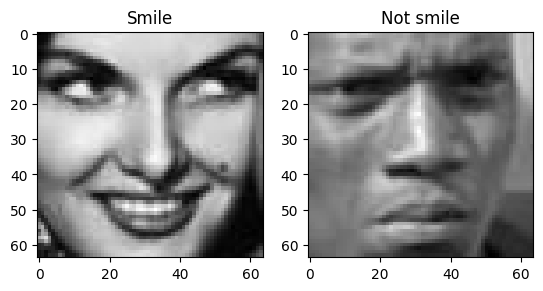

In [ ]:
plt.subplot(121)
plt.title("Smile")
plt.imshow(smile[0], cmap='gray')

plt.subplot(122)
plt.title("Not smile")
plt.imshow(non_smile[0], cmap='gray')

plt.show()

print the smiling and non-smiling data + the united dataset along with labels.

In [ ]:
print(f'smile array size is (images, height, width)={smile.shape}')
print(f'non smile array size is (images, height, width)={non_smile.shape}')
print()
print(f'dataset array size is {dataset.shape}')
print(f'labels array size is {labels.shape}')

smile array size is (images, height, width)=(600, 64, 64)
non smile array size is (images, height, width)=(603, 64, 64)

dataset array size is (1203, 64, 64)
labels array size is (1203,)


Prepear train and test datasets, print their structure. Since you have to deal with 1d features, we flatten the squared image

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.2, stratify=labels, random_state=42)

print(f'train size is {x_train.shape} and labels size is {y_train.shape}')
print(f'test size is {x_test.shape} and labels size is {y_test.shape}')
print()

x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print(f'flattened train size is {x_train_flatten.shape} ')
print(f'flattened test size is {x_test_flatten.shape}')

train size is (962, 64, 64) and labels size is (962,)
test size is (241, 64, 64) and labels size is (241,)

flattened train size is (962, 4096) 
flattened test size is (241, 4096)


## Part 3 - PCA, LDA

We will try to classify the smiling faces dataset using feature reduction and KNN (since there are 4096 features!). Than you will compare it to LDA

import libraries

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

Implement PCA to reduce the dimension of the images from 4096=64x64 to 81=9x9. For time effciency, DONT use any loops here.

Hint: Implement inverse_transform to recover the original vector from the compressed one. <br/>
Hint: When dealing with symmetric matrix, you can call eigh instead of eig function of numpy, its much faster.

In [ ]:
def PCA_train(data, k):
    mu = data.mean(axis=0)
    print(mu.shape)
    print(data.shape)
    Z = data - mu
    S = np.matmul(Z.T, Z)
    print(S.shape)
    eigen_values, eigen_vectors = np.linalg.eigh(S)
    sorted_indices = np.argsort(eigen_values)[::-1]
    largest_k_indices = sorted_indices[:k]
    E = eigen_vectors[:, largest_k_indices].transpose()
    y = np.matmul(E, Z.transpose())
    print(y.shape)
    return y, mu, E, eigen_values


def PCA_test(test, mu, E):
    # Implement here
    Z = test - mu
    y = np.matmul(E, Z.transpose())
    return y


def recover_PCA(data, mu, E):
    # Implement here
    y=np.matmul( E.T, data) + mu[:, np.newaxis]
    print(y.shape)
    return y


Apply the PCA. <br/>
Make sure you fit the PCA model only to the training set (but apply it to both training and test sets). <br/>

In [ ]:
x_train_new, mu, eig, eig_list = PCA_train(x_train_flatten, 81)  # Implement here
x_test_new = PCA_test(x_test_flatten, mu, eig) # Implement here

(4096,)
(962, 4096)
(4096, 4096)
(81, 962)


Pick another random image and show the result of applying PCA to it, and then try to recover the whole size again.

(4096, 962)


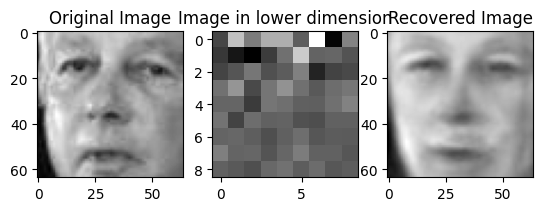

In [ ]:
plt.subplot(131)
plt.title("Original Image")
plt.imshow(x_train[0], cmap='gray')

x_train_trans = x_train_new.transpose()
pho = x_train_trans[0]
pho = pho.reshape(9, 9)

plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(pho , cmap='gray')


x_train_recovered_all = recover_PCA(x_train_new, mu, eig)
x_train_recovered_all_trans = x_train_recovered_all.transpose()
pho_recovered = x_train_recovered_all_trans[0]
pho_recovered = pho_recovered.reshape(64, 64)

plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(pho_recovered, cmap='gray')

plt.show()

Use EIG_CDF, that given eigenvalues, draws a CDF of them like here:<br/><br/>

![Picture1.jpg](https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcS3mOZk1x4X3ap9nuMnst5W5pMgOXF8r3Tmx1QcFX9mba_lleuB)

As seen in the tutorials, we use them to see how much "energy" we preserve from the data. Use this to choose optimal dimension to reduce into, such the preserves 95% of the energy.

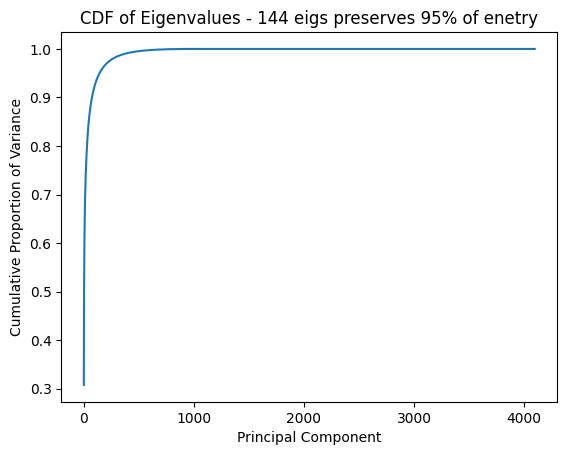

In [ ]:
def EIG_CDF(eig_list):
	sorted_eigenvalues = np.sort(eig_list)[::-1]

	eigenvalues_cumsum = np.cumsum(sorted_eigenvalues)

	eigenvalues_cumsum_normalized = eigenvalues_cumsum / eigenvalues_cumsum[-1]
	amount = np.argmax(eigenvalues_cumsum_normalized >= 0.95) + 1 # Implement here

	plt.plot(np.arange(1, len(sorted_eigenvalues)+1), eigenvalues_cumsum_normalized)
	plt.xlabel('Principal Component')
	plt.ylabel('Cumulative Proportion of Variance')
	plt.title(f'CDF of Eigenvalues - {amount} eigs preserves 95% of enetry')
	plt.show()

# Call to EIG_CDF
EIG_CDF(eig_list)

For the same image as before, show the result of applying PCA to it and recovering.<br/>
Is the result better? What is different from 81 dimensions? <br/>
Answer : The result is better, meaning the recovered image is more recognizable and clear. This improvement occurs because in 144 dimensions, more principal components are retained, capturing more of the original image's variance. Thus, more details and features of the image are preserved compared to the 81 dimensions case.</font>

(4096,)
(962, 4096)
(4096, 4096)
(144, 962)
(4096, 962)


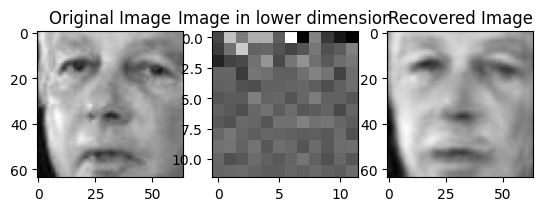

In [ ]:
x_train_new_new_k, mu, eig_new_k, eig_list = PCA_train(x_train_flatten, 144)
x_test_new_new_k = PCA_test(x_test_flatten, mu, eig_new_k)

x_train_trans_new_k = x_train_new_new_k.transpose()
x_test_trans_new_k = x_test_new_new_k.transpose()

plt.subplot(131)
plt.title("Original Image")
plt.imshow(x_train[0], cmap='gray')

pho_new_k = x_train_trans_new_k[0]
pho_new_k = pho_new_k.reshape(12, 12)

plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(pho_new_k, cmap='gray')

x_train_recovered_all_new_k = recover_PCA(x_train_new_new_k, mu, eig_new_k)
x_train_recovered_all_trans_new_k = x_train_recovered_all_new_k.transpose()
pho_recovered_new_k = x_train_recovered_all_trans_new_k[0]
pho_recovered_new_k = pho_recovered_new_k.reshape(64, 64)

plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(pho_recovered_new_k, cmap='gray')

plt.show()

Now, we are ready to train the model. Using KNN, tune the best k using cross_val_score (with sklearn)

best k is 74


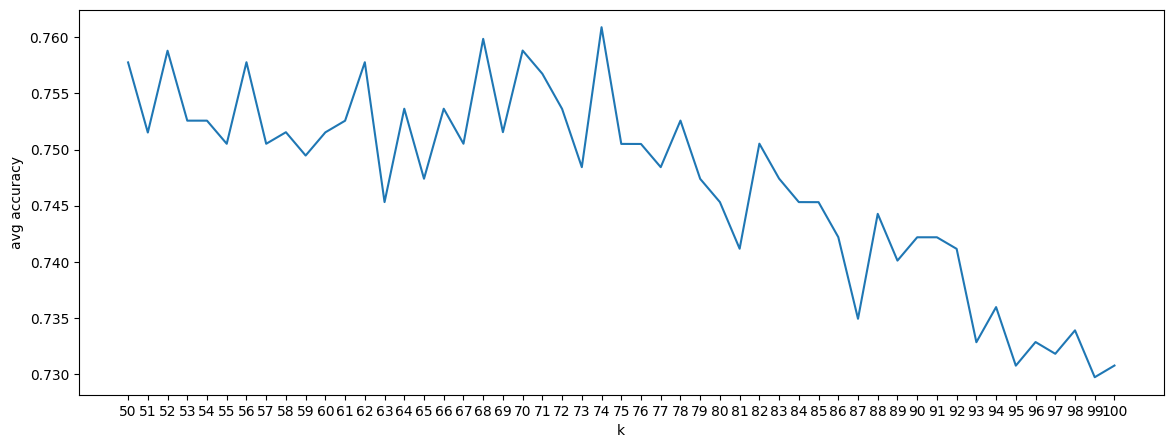

In [ ]:
# Implement here
ks = range(50, 101)
accs = []
for k in ks:
  knn = KNeighborsClassifier(n_neighbors=k)
  acc = cross_val_score(knn, x_train_trans_new_k, y_train).mean()
  accs.append(acc)

best_k = ks[np.argmax(accs)]
print(f'best k is {best_k}')

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(x_train_trans_new_k, y_train)


plt.figure(figsize=(14,5))
plt.plot(ks, accs)
plt.xlabel('k')
plt.xticks(ks)
plt.ylabel('avg accuracy')
plt.show()

Print the accuracy of your model on the test set.

In [ ]:
# Implement here
y_pred = best_knn.predict(x_test_trans_new_k)
acc = best_knn.score(x_test_trans_new_k, y_test)
print(f'acc on test is {acc}')

acc on test is 0.7800829875518672



- What pre-proccessing actions were done on the data?
- Should we apply Standard Scaler? Why?
- Suggest one idea for improvement (rather than LDA)

1-The pre-proccessing actions were done on the data: flattening the data, splitting the dataset into training and test sets, converting the images to grayscale, loading both smiling and non-smiling data,and merging the images into a single dataset, and normalizing the data.

2- We shouldn't apply Standard Scaler because it can change the pixel values, which can negatively affect the display of the photo. However, when working with PCA, we normalize the data. Normalizing the data puts them on the same scale(which is necessary for KNN) without altering the relationships and values.

3-I suugest way for improvment that consider experimenting with different distance metrics for measuring distances between data points. for instance, we can use the Manhattan distance, which sums absolute differences to calculate distance. This metric may be more effective at handling outliers and managing features with varying scales, thereby potentially enhancing the model's performance.
</font>


For the second part, we will use LDA on the data <b>before</b> PCA. <br/>
Use the model of LinearDiscriminantAnalysis from Sklearn, train the data and print the accuracy test using KNN. <br/>
Use the best k you found earlier.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def LDA_train_test(train_data, train_labels, test_data):
  lda = LinearDiscriminantAnalysis(n_components=1)
  x_train_d1 = lda.fit_transform(train_data, train_labels)
  x_test_d1 = lda.transform(test_data)

  knn_lda = KNeighborsClassifier(n_neighbors=best_k)
  knn_lda.fit(x_train_d1, train_labels)
  y_pred_lda = knn_lda.predict(x_test_d1)
  acc_lda = knn_lda.score(x_test_d1, y_test)
  return acc_lda


# LDA before PCA
acc_lda = LDA_train_test(x_train_flatten, y_train, x_test_flatten)
print(f'acc on test LDA before PCA is: {acc_lda}')

#LDA after PCA
acc_lda_pca = LDA_train_test(x_train_trans_new_k, y_train, x_test_trans_new_k)
print(f'acc on test LDA after PCA is: {acc_lda_pca}')

acc on test LDA before PCA is: 0.7759336099585062
acc on test LDA after PCA is: 0.8630705394190872


Now, repeat the same as above, but using the data <b>after</b> PCA and using the same k.
- Was the combination of PCA and LDA helpful more than LDA alone?
- Comparing LDA alone vs PCA alone (as dimensionality reduction), which one was better to this problem? Justify.

The combination of PCA and LDA is more helpful than using LDA alone because: 1_LDA assumes that the features are uncorrelated, but if they are correlated, LDA doesn't perform well. By using PCA first, we transform the features to be uncorrelated, making LDA work better.2_ LDA works better when the number of features is smaller. PCA helps by reducing the number of features before applying LDA, improving its performance.
When we use LDA alone, we get an accuracy of 0.7759. When we use PCA alone, we get an accuracy of 0.7801, which is better for this problem.LDA reduces the number of features to at least C-1 features (C is the number of classes), so from 4096 features, it reduces to 1 feature. Since the number of features in this problem is high, LDA alone is not a good idea.On the other hand, PCA optimally reduces the dimensionality with minimal data loss. Specifically for our problem, PCA reduces the features from 4096 to 144 dimensions, which results in better accuracy.
</font>